## Project: Books Recommender System

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve,auc,roc_auc_score, mean_squared_error


'''Keras and TensorFlow'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten
from keras.layers import dot
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse,binary_crossentropy



Using TensorFlow backend.


### Loading Data

In [2]:
# Loading data

books = pd.read_csv('books.csv')
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [3]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [4]:
toread = pd.read_csv('to_read.csv')
toread.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
user_id    int64
book_id    int64
rating     int64
dtypes: int64(3)
memory usage: 136.8 MB


In [6]:
ratings.describe()

,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


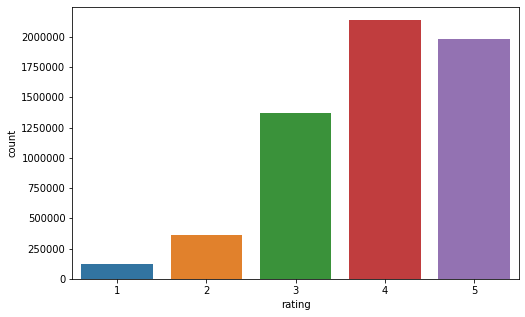

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(x="rating", data=ratings)
plt.show()

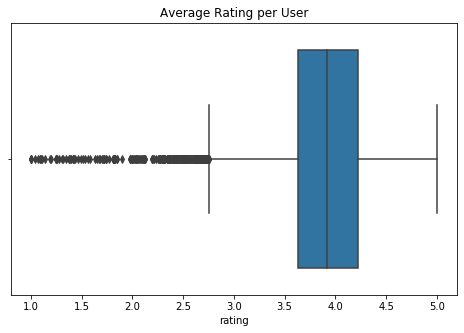

In [8]:
plt.figure(figsize=(8,5))
rating_avg_per_user = ratings[['user_id','rating']].groupby('user_id').mean().sort_values(by=['rating'], ascending=False)
sns.boxplot(x='rating', data=rating_avg_per_user)
plt.title('Average Rating per User')
plt.show()

In [9]:
ratings[['user_id','book_id']].groupby('user_id').count().sort_values(by=['user_id'], ascending=False)

,book_id
user_id,
53424,133
53423,77
53422,130
53421,110
53420,110
...,...
5,100
4,134
3,91


No null values in dataset


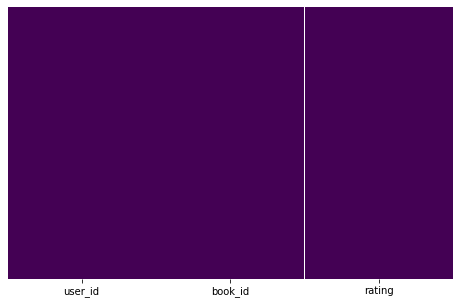

In [10]:
plt.figure(figsize=(8,5))
print('No null values in dataset')
sns.heatmap(ratings.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

In [11]:
#Let's verify how many unique users and books there are into the dataset

n_users = ratings.user_id.unique().shape[0]
n_books = ratings.book_id.unique().shape[0]

print('Number of unique users: {} '.format(n_users))
print('Number of unique books: {} '.format(n_books))

Number of unique users: 53424 
Number of unique books: 10000 


In [12]:
#To reduce the complexity and size of this dataset, let's take the top one thousand most rated books

bookIndex = ratings.groupby('book_id').count().sort_values(by='rating',ascending=False)[0:1000].index

ratings_2 = ratings[ratings.book_id.isin(bookIndex)]
ratings_2.count()

user_id    3179650
book_id    3179650
rating     3179650
dtype: int64

In [13]:
#Let's take just 1000 of users, to reduce the number of ratings from 3179650 to 1000

userIndex = ratings_2.groupby('user_id').count().sort_values(
                by='rating',ascending=False).sample(n=1000,random_state=2020).index

reducedRatings = ratings_2[ratings_2.user_id.isin(userIndex)]


In [14]:
#Let's reindex book_id and user_id to a range from 1 to 1000 for reduce dataset

bookIDs = reducedRatings.book_id.unique()
bookDF = pd.DataFrame(data=bookIDs,columns=['originalBookId'])
bookDF['newBookId'] = bookDF.index+1


userIDs = reducedRatings.user_id.unique()
userDF = pd.DataFrame(data=userIDs, columns=['originalUserId'])
userDF['newUserId'] = userDF.index+1

reducedRatings = reducedRatings.merge(bookDF, left_on='book_id', right_on='originalBookId')
reducedRatings.drop(labels='originalBookId', axis=1, inplace=True)

reducedRatings = reducedRatings.merge(userDF, left_on='user_id',right_on='originalUserId')
reducedRatings.drop(labels='originalUserId', axis=1, inplace=True)


In [15]:
reducedRatings.head()

,user_id,book_id,rating,newBookId,newUserId
0,73,758,5,1,1
1,73,268,4,2,1
2,73,820,5,3,1
3,73,380,5,4,1
4,73,851,4,5,1


In [16]:
n_users = reducedRatings.user_id.unique().shape[0]
n_books = reducedRatings.book_id.unique().shape[0]
n_ratings = len(reducedRatings)

print('Number of unique users: {} '.format(n_users))
print('Number of unique books: {} '.format(n_books))
print('Number of ratings: {} '.format(n_ratings))


Number of unique users: 1000 
Number of unique books: 1000 
Number of ratings: 58851 


In [17]:
#Let's generate a test set and validation set

X_train, X_test = train_test_split(reducedRatings, test_size = 0.10, shuffle=True, random_state=2020)
X_validation, X_test = train_test_split(reducedRatings, test_size = 0.50, shuffle=True, random_state=2020)


print('Train set size: {} '.format(len(X_train)))
print('Validation set size: {} '.format(len(X_validation)))
print('Test set size: {} '.format(len(X_test)))

Train set size: 52965 
Validation set size: 29425 
Test set size: 29426 


## Approach 1: Content Based Recommended Systems

In [18]:
# Creating a rating matrix for train u x b, 
# where u are the users and the b are the books

ratings_train = np.zeros((n_users,n_books))
for row in X_train.itertuples():    
    ratings_train[row[5]-1, row[4]-1] = row[3]


#Calculating sparcity of train matrix
sparcity = float(len(ratings_train.nonzero()[0]))
sparcity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparcity *= 100
print('Sparcity: {}'.format(round(sparcity,2)))

Sparcity: 5.3


In [19]:
# Creating a rating matrix for validation u x b, 
# where u are the users and the b are the books

ratings_validation = np.zeros((n_users,n_books))
for row in X_validation.itertuples():    
    ratings_validation[row[5]-1, row[4]-1] = row[3]


# Creating a rating matrix for test u x b, 
# where u are the users and the b are the books

ratings_test = np.zeros((n_users,n_books))
for row in X_test.itertuples():    
    ratings_test[row[5]-1, row[4]-1] = row[3]


In [20]:
# Predicting an average rating of 3.5 for the validation set and calculating MSE

actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5
pred_validation

mse = mean_squared_error(pred_validation,actual_validation)

print('Mean squared error using naive prediction: {}'.format(mse))

Mean squared error using naive prediction: 1.2081648258283773


In [21]:
# Predicting based on user's average of all books

ratings_validation_prediction = np.zeros((n_users,n_books))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1
    
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation,actual_validation)

print('Mean squared error using user average: {}'.format(user_average))

Mean squared error using user average: 0.8434119929918782


In [22]:
# Predicting a users'rating for a given book based on the average rating all books

ratings_validation_prediction = np.zeros((n_users, n_books)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1
    
ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()

book_average = mean_squared_error(pred_validation,actual_validation)
print('Mean squared error using book average: {}'.format(book_average))

Mean squared error using book average: 0.9427778575574443


## Approach 2: Latent Factor Based or Matrix Factorization

In [23]:
def perform_MF(latent_factors):

    ''' 
    perform_MF receives a number of latent_factors
    
    '''
    
    n_latent_factors = latent_factors

    user_input = Input(shape=[1],name='user')
    user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors,
                              name='user_embedding')(user_input)
    user_vector = Flatten(name='flatten_users')(user_embedding)


    book_input = Input(shape=[1],name='books')
    book_embedding = Embedding(input_dim=n_books + 1, output_dim=n_latent_factors,
                              name='book_embedding')(book_input)
    book_vector = Flatten(name='flatten_books')(book_embedding)
    
    
    # Generating the output vector to take the dot product of book vector and user vector

    product = dot([user_vector,book_vector], axes=1)
    model = Model(inputs=[user_input,book_input], outputs=product)
    model.compile('adam','mean_squared_error')
    
    # Training model with book and user vectors from the training dataset

    history = model.fit(x=[X_train.newUserId, X_train.newBookId],
                   y=X_train.rating, epochs=100,
                   validation_data=([X_validation.newUserId, 
                   X_validation.newBookId], X_validation.rating),
                   verbose=0)    
    


    return history

### One Latent Factor

In [24]:
history = perform_MF(1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Minimum MSE:  0.7550142366965139


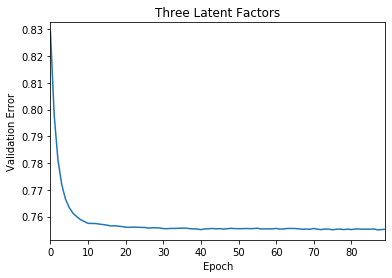

In [25]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Three Latent Factors')

print('Minimum MSE: ',min(history.history['val_loss']))

### Three Latent Factor

In [26]:
history = perform_MF(3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Minimum MSE:  0.6204861236043977


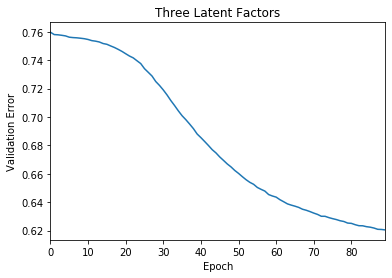

In [28]:
# PLotting results

pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Three Latent Factors')

print('Minimum MSE: ',min(history.history['val_loss']))

### Five Latent Factors

In [29]:
history = perform_MF(5)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Minimum MSE:  0.5179431718451144


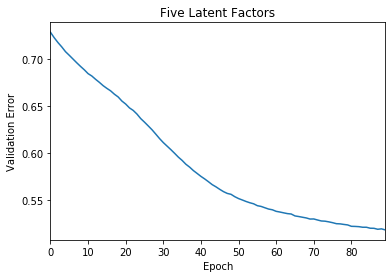

In [30]:
# PLotting results

pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Five Latent Factors')

print('Minimum MSE: ',min(history.history['val_loss']))

### Ten Factors Latent


In [31]:
history = perform_MF(10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Minimum MSE:  0.3332777925710508


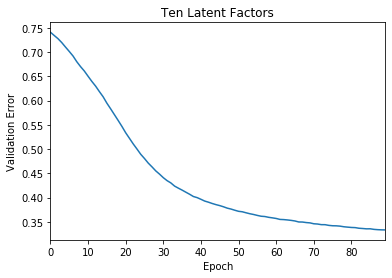

In [32]:
# PLotting results

pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Ten Latent Factors')

print('Minimum MSE: ',min(history.history['val_loss']))

### Creating a Keras Model

In [33]:
# Creating the model with ten factor latent

n_latent_factors = 10

# User vector
user_input = Input(shape=[1],name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, 
                           name='user_embedding')(user_input)
user_vector = Flatten(name='flatten_users')(user_embedding)


# Book vector
book_input = Input(shape=[1],name='books')
book_embedding = Embedding(input_dim=n_books + 1, output_dim=n_latent_factors,
                          name='book_embedding')(book_input)
book_vector = Flatten(name='flatten_books')(book_embedding)


# Generating the output vector to take the dot product of book vector and user vector
product = dot([user_vector,book_vector], axes=1)

# Creating the model
model = Model(inputs=[user_input,book_input], outputs=product)
model.compile('adam','mean_squared_error', metrics=['accuracy'])

# Training the model
history = model.fit(x=[X_train.newUserId, X_train.newBookId],
               y=X_train.rating, 
               epochs=100,
               validation_data=([X_validation.newUserId, X_validation.newBookId], 
               X_validation.rating),
               verbose=1)    

model.summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 52965 samples, validate on 29425 samples
Epoch 1/100
52965/52965 [==============================] - 2s 31us/step - loss: 15.3120 - accuracy: 0.0022 - val_loss: 11.4090 - val_accuracy: 0.0176
Epoch 2/100
52965/52965 [==============================] - 2s 30us/step - loss: 6.0527 - accuracy: 0.0995 - val_loss: 2.5556 - val_accuracy: 0.2229
Epoch 3/100
52965/52965 [==============================] - 2s 35us/step - loss: 1.6513 - accuracy: 0.2991 - val_loss: 1.0594 - val_accuracy: 0.3689
Epoch 4/100
52965/52965 [==============================] - 2s 31us/step - loss: 0.9330 - accuracy: 0.3926 - val_loss: 0.8068 - val_accuracy: 0.4236
Epoch 5/100
52965/52965 [==============================] - 2s 29us/step - loss: 0.8078 - accuracy: 0.4274 - val_loss: 0.7594 - val_accuracy: 0.4409
Epoch 6/100
52965/52965 [==============================] - 2s 31us/step - loss: 0.7808 - accuracy: 0.4357 - val_loss: 0.7447 - val_accuracy: 0.4474
Epoch 7/100
52965/52965 [==============================] - 2

Epoch 56/100
52965/52965 [==============================] - 2s 31us/step - loss: 0.4096 - accuracy: 0.6056 - val_loss: 0.3800 - val_accuracy: 0.6260
Epoch 57/100
52965/52965 [==============================] - 2s 30us/step - loss: 0.4069 - accuracy: 0.6084 - val_loss: 0.3775 - val_accuracy: 0.6293
Epoch 58/100
52965/52965 [==============================] - 2s 31us/step - loss: 0.4046 - accuracy: 0.6097 - val_loss: 0.3752 - val_accuracy: 0.6305
Epoch 59/100
52965/52965 [==============================] - 2s 30us/step - loss: 0.4022 - accuracy: 0.6098 - val_loss: 0.3736 - val_accuracy: 0.6324
Epoch 60/100
52965/52965 [==============================] - 2s 31us/step - loss: 0.4005 - accuracy: 0.6124 - val_loss: 0.3715 - val_accuracy: 0.6340
Epoch 61/100
52965/52965 [==============================] - 2s 31us/step - loss: 0.3984 - accuracy: 0.6122 - val_loss: 0.3694 - val_accuracy: 0.6319
Epoch 62/100
52965/52965 [==============================] - 2s 31us/step - loss: 0.3964 - accuracy: 0.6157

In [38]:
scores = model.evaluate(x=[X_test.newUserId, X_test.newBookId],
               y=X_test.rating, batch_size=128)

print(scores)

29426/29426 [==============================] - 0s 4us/step
[0.4863946427403969, 0.6127574443817139]


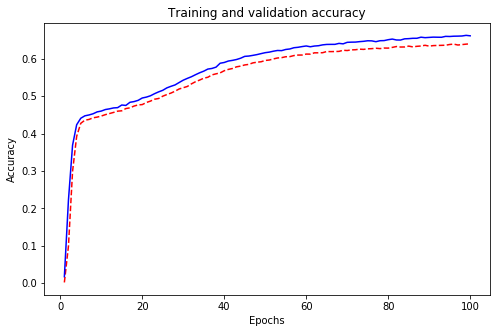

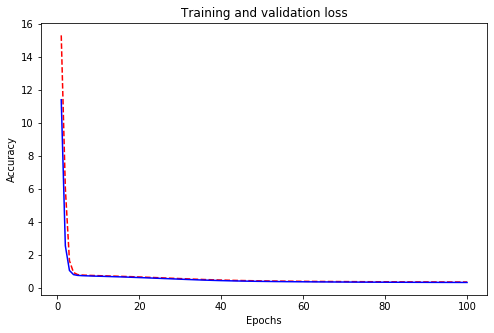

In [62]:
#Plotting training vs validation accuracy and loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,5))
epochs   = range(1,len(acc)+1,1)

plt.plot(epochs,acc, 'r--', label='Training acc'  )
plt.plot(epochs, val_acc,  'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()


plt.figure(figsize=(8,5))
plt.plot(epochs,loss,'r--')
plt.plot(epochs, val_loss,'b')
plt.title('Training and validation loss')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

### Predictions for a mock user 

In [41]:
# Creating a dataset for making recommendations for user 1

user_number = 1

book_data = np.array(list(set(reducedRatings.newBookId)))
user_data = np.array([user_number for i in range(len(book_data))])

predictions = model.predict([user_data, book_data])
predictions = np.array([a[0] for a in predictions])
recommended_newbookids = (-predictions).argsort()[:5]
recommendedBookIds = reducedRatings[reducedRatings['newBookId'].isin(recommended_newbookids)]['book_id'].unique()


print('Recommended books for user: {}'.format(user_number))
print(books[books['book_id'].isin(recommendedBookIds)][['original_title','authors']])

Recommended books for user: 1
                                         original_title             authors
185                               The Other Boleyn Girl    Philippa Gregory
467                        Their Eyes Were Watching God  Zora Neale Hurston
870                                  Dead in the Family    Charlaine Harris
880   The Man Who Mistook His Wife for a Hat and Oth...        Oliver Sacks
1018                                    Childhood's End    Arthur C. Clarke


## Approach 3: Restricted Boltzmman Machines

In [63]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


# Defining RBM Class

class RBM(object):
    
    def __init__(self, input_size, output_size, learning_rate,epochs, batchsize):
        
        #Defining hyperparameters        
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        #Initializing weights and biases using zero matrices
        self.w = np.zeros([input_size,output_size],'float')
        self.hb = np.zeros([output_size], 'float')
        self.vb = np.zeros([input_size], 'float')   
    
        
    # Forward pass
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)


    #Backward pass
    def prob_v_given_h(self, hidden, w, vb):
        vb = tf.cast(vb, tf.float32)
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    
    #Sampling Function (Gibss Sampling)
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))
    
    
    # Output Function
    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))        
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out),sess.run(visibleGen),sess.run(hiddenGen)
        


    # Train function    
    def train(self, X, user=1):
    
        # Creating placeholders for weight matrix, hidden bias vector and visible bias vector
        _w = tf.placeholder('float', [self._input_size, self._output_size])
        _hb = tf.placeholder('float',[self._output_size])
        _vb = tf.placeholder('float',[self._input_size])

        # Initializing values in zeros for variables above, to hold previous values
        prv_w = np.zeros([self._input_size,self._output_size], 'float')
        prv_hb = np.zeros([self._output_size],'float')
        prv_vb = np.zeros([self._input_size],float)

        # Initializing values in zeros for variables above, to hold current values
        cur_w = np.zeros([self._input_size,self._output_size], 'float')
        cur_hb = np.zeros([self._output_size],'float')
        cur_vb = np.zeros([self._input_size],float)

        # Creating placeholder for visible layer
        v0 = tf.placeholder('float',[None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))

        # Setting the output forward pass (v1) and adding the visible bias vector
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Defining the error as MSE
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)


        # Create methods to update the weights and biases
        update_w = _w + self.learning_rate * (positive_grad - negative_grad)/tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1,0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1,0)
        
        
        err = tf.reduce_mean(tf.square(v0 - v1))        
        error_list = []
        
        
        # Initializing the TensorFlow Session with defined variables 
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch in range(self.epochs):

                for start, end in zip(range(0, len(X),
                    self.batchsize),range(self.batchsize,len(X), self.batchsize)):

                    batch = X[start:end]
                    
                    cur_w = sess.run(update_w, feed_dict={
                        v0 : batch,
                        _w : prv_w,
                        _hb : prv_hb,
                        _vb : prv_vb})
                    
                    cur_hb = sess.run(update_hb, feed_dict={
                        v0 : batch,
                        _w : prv_w,
                        _hb : prv_hb,
                        _vb : prv_vb})
                    
                    cur_vb = sess.run(update_vb, feed_dict={
                        v0 : batch,
                        _w : prv_w,
                        _hb : prv_hb,
                        _vb : prv_vb})
                    
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                    
                    error = sess.run(err, feed_dict={v0:X, _w:cur_w, _vb:cur_vb, _hb: cur_hb})
                    error_list.append(error)
                    
                    print('Epoch: {} ,reconstruction error: {} '.format(epoch, error))

           
            
            # Feeding the User
            
            inputUser = [X[user]]
            hh0 = tf.nn.sigmoid(tf.matmul(v0,_w) + _hb)
            vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(_w)) + _vb)
            feed = sess.run(hh0, feed_dict={v0: inputUser, _w: prv_w, _hb: prv_hb})
            rec = sess.run(vv1, feed_dict={hh0: feed, _w: prv_w, _vb: prv_vb})

            self.w = prv_w
            self.hb = prv_hb
            self_vb = prv_vb  
            
            return error_list,rec


    # Obtaining recommendation for an user    
    def calculate_scores(self, ratings, books, to_read, rec, user):
        
        
        # Creating recommendation score for books in our data
        num_rows = 1000
        temp = ratings.sort_values(by=['user_id'], ascending=True)
        ratings = temp.iloc[:num_rows, :]
        ratings['Recommendation_Score'] = rec[0]

        
        # Finding mock user's user_id from the data
        cur_user_id = ratings.iloc[user]['user_id']

        # Finding books the user has read before
        read_books = ratings[ratings['user_id'] == cur_user_id]['book_id']
        read_books

        # Converting the pandas object into a list
        read_books_id = read_books.tolist()

        # Getting book names and authors for the books already read by the user
        read_books_names = []
        read_books_authors = []
        for book in read_books_id:
            read_books_names.append(
                books[books['book_id'] == book]['original_title'].tolist()[0])
            read_books_authors.append(
                books[books['book_id'] == book]['authors'].tolist()[0])

        # Finding all books the mock user has 'not' read before using the to_read data
        unread_books = to_read[to_read['user_id'] == cur_user_id]['book_id']
        unread_books_id = unread_books.tolist()

        # Extracting  ratings of all the unread books from ratings dataframe
        unread_with_score = ratings[ratings['book_id'].isin(unread_books_id)]

        # Grouping the unread data on book id and taking the mean of the recommendation scores for each book_id
        grouped_unread = unread_with_score.groupby('book_id', as_index=False)[
            'Recommendation_Score'].mean()

        # Getting the names and authors of the unread books
        unread_books_names = []
        unread_books_authors = []
        unread_books_scores = []
        for book in grouped_unread['book_id']:
            unread_books_names.append(
                books[books['book_id'] == book]['original_title'].tolist()[0])
            unread_books_authors.append(
                books[books['book_id'] == book]['authors'].tolist()[0])
            unread_books_scores.append(
                grouped_unread[grouped_unread['book_id'] == book]['Recommendation_Score'].tolist()[0])

        # Creating a data frame for unread books with their names, authors and recommendation scores
        unread_books_with_scores = pd.DataFrame({
            'book_name': unread_books_names,
            'book_authors': unread_books_authors,
            'score': unread_books_scores
        })

        # Creating a data frame for read books with the names and authors
        read_books_with_names = pd.DataFrame({
            'book_name': read_books_names,
            'book_authors': read_books_authors
        })

        return unread_books_with_scores, read_books_with_names

In [46]:
# Training the model

inputX = ratings_train
inputX = inputX.astype(np.float32)

#Parameters: input_size, output_size, learning_rate, epochs, batchsize

rbm = RBM(1000,1000,0.3,500,200)

In [47]:
# Train RBM model
err,rec = rbm.train(inputX,1)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 ,reconstruction error: 0.8912540078163147 
Epoch: 0 ,reconstruction error: 0.9642329812049866 
Epoch: 0 ,reconstruction error: 0.9524359703063965 
Epoch: 0 ,reconstruction error: 0.9155380129814148 
Epoch: 1 ,reconstruction error: 0.8965250253677368 
Epoch: 1 ,reconstruction error: 0.892562985420227 
Epoch: 1 ,reconstruction error: 0.8893089890480042 
Epoch: 1 ,reconstruction error: 0.8784869909286499 
Epoch: 2 ,reconstruction error: 0.8869739770889282 
Epoch: 2 ,reconstruction error: 0.8760889768600464 
Epoch: 2 ,reconstruction error: 0.863523006439209 
Epoch: 2 ,reconstruction error: 0.864238977432251 
Epoch: 3 ,reconstruction error: 0.867048978805542 
Epoch: 3 ,reconstruction error: 0.8666170239448547 
Epoch: 3 ,reconstruction error: 0.8577759861946106 
Epoch: 3 ,reconstruction error: 0.8573240041732788 
Epoch: 4 ,reconstruction error: 0.8626670241355896 
Epoch: 4 ,reconstruction error: 0.8617460131645203 
Epoch: 4 ,reconstr

Epoch: 38 ,reconstruction error: 0.8133760094642639 
Epoch: 38 ,reconstruction error: 0.8044930100440979 
Epoch: 38 ,reconstruction error: 0.8077920079231262 
Epoch: 39 ,reconstruction error: 0.8145509958267212 
Epoch: 39 ,reconstruction error: 0.8091099858283997 
Epoch: 39 ,reconstruction error: 0.8016290068626404 
Epoch: 39 ,reconstruction error: 0.8076940178871155 
Epoch: 40 ,reconstruction error: 0.8119570016860962 
Epoch: 40 ,reconstruction error: 0.8076289892196655 
Epoch: 40 ,reconstruction error: 0.8008139729499817 
Epoch: 40 ,reconstruction error: 0.805342972278595 
Epoch: 41 ,reconstruction error: 0.8126569986343384 
Epoch: 41 ,reconstruction error: 0.8062689900398254 
Epoch: 41 ,reconstruction error: 0.7986310124397278 
Epoch: 41 ,reconstruction error: 0.8033549785614014 
Epoch: 42 ,reconstruction error: 0.8093910217285156 
Epoch: 42 ,reconstruction error: 0.8051660060882568 
Epoch: 42 ,reconstruction error: 0.7977589964866638 
Epoch: 42 ,reconstruction error: 0.801467001438

Epoch: 77 ,reconstruction error: 0.789251983165741 
Epoch: 77 ,reconstruction error: 0.7890520095825195 
Epoch: 78 ,reconstruction error: 0.7966679930686951 
Epoch: 78 ,reconstruction error: 0.7978370189666748 
Epoch: 78 ,reconstruction error: 0.7891389727592468 
Epoch: 78 ,reconstruction error: 0.7883999943733215 
Epoch: 79 ,reconstruction error: 0.7966769933700562 
Epoch: 79 ,reconstruction error: 0.7969629764556885 
Epoch: 79 ,reconstruction error: 0.788968026638031 
Epoch: 79 ,reconstruction error: 0.7888489961624146 
Epoch: 80 ,reconstruction error: 0.7963690161705017 
Epoch: 80 ,reconstruction error: 0.7974740266799927 
Epoch: 80 ,reconstruction error: 0.788923978805542 
Epoch: 80 ,reconstruction error: 0.7888510227203369 
Epoch: 81 ,reconstruction error: 0.7960879802703857 
Epoch: 81 ,reconstruction error: 0.7974889874458313 
Epoch: 81 ,reconstruction error: 0.7885429859161377 
Epoch: 81 ,reconstruction error: 0.7891499996185303 
Epoch: 82 ,reconstruction error: 0.79565799236297

Epoch: 116 ,reconstruction error: 0.7904639840126038 
Epoch: 116 ,reconstruction error: 0.7926809787750244 
Epoch: 116 ,reconstruction error: 0.7871249914169312 
Epoch: 116 ,reconstruction error: 0.7866960167884827 
Epoch: 117 ,reconstruction error: 0.7902510166168213 
Epoch: 117 ,reconstruction error: 0.792264997959137 
Epoch: 117 ,reconstruction error: 0.7871509790420532 
Epoch: 117 ,reconstruction error: 0.7865899801254272 
Epoch: 118 ,reconstruction error: 0.7902230024337769 
Epoch: 118 ,reconstruction error: 0.79230797290802 
Epoch: 118 ,reconstruction error: 0.7876859903335571 
Epoch: 118 ,reconstruction error: 0.78615802526474 
Epoch: 119 ,reconstruction error: 0.7907320261001587 
Epoch: 119 ,reconstruction error: 0.7919650077819824 
Epoch: 119 ,reconstruction error: 0.787397027015686 
Epoch: 119 ,reconstruction error: 0.7867079973220825 
Epoch: 120 ,reconstruction error: 0.7899730205535889 
Epoch: 120 ,reconstruction error: 0.7921959757804871 
Epoch: 120 ,reconstruction error: 

Epoch: 154 ,reconstruction error: 0.785847008228302 
Epoch: 154 ,reconstruction error: 0.7852150201797485 
Epoch: 155 ,reconstruction error: 0.7875009775161743 
Epoch: 155 ,reconstruction error: 0.789991021156311 
Epoch: 155 ,reconstruction error: 0.7857620120048523 
Epoch: 155 ,reconstruction error: 0.7853620052337646 
Epoch: 156 ,reconstruction error: 0.7873470187187195 
Epoch: 156 ,reconstruction error: 0.7902699708938599 
Epoch: 156 ,reconstruction error: 0.7857239842414856 
Epoch: 156 ,reconstruction error: 0.785260021686554 
Epoch: 157 ,reconstruction error: 0.787276029586792 
Epoch: 157 ,reconstruction error: 0.7902979850769043 
Epoch: 157 ,reconstruction error: 0.7858200073242188 
Epoch: 157 ,reconstruction error: 0.7850930094718933 
Epoch: 158 ,reconstruction error: 0.7875779867172241 
Epoch: 158 ,reconstruction error: 0.790369987487793 
Epoch: 158 ,reconstruction error: 0.7858139872550964 
Epoch: 158 ,reconstruction error: 0.7851459980010986 
Epoch: 159 ,reconstruction error:

Epoch: 193 ,reconstruction error: 0.7864900231361389 
Epoch: 193 ,reconstruction error: 0.7890530228614807 
Epoch: 193 ,reconstruction error: 0.7853389978408813 
Epoch: 193 ,reconstruction error: 0.7846620082855225 
Epoch: 194 ,reconstruction error: 0.7865639925003052 
Epoch: 194 ,reconstruction error: 0.7888969779014587 
Epoch: 194 ,reconstruction error: 0.7855100035667419 
Epoch: 194 ,reconstruction error: 0.7843850255012512 
Epoch: 195 ,reconstruction error: 0.786083996295929 
Epoch: 195 ,reconstruction error: 0.7890160083770752 
Epoch: 195 ,reconstruction error: 0.7854620218276978 
Epoch: 195 ,reconstruction error: 0.7849439978599548 
Epoch: 196 ,reconstruction error: 0.7862589955329895 
Epoch: 196 ,reconstruction error: 0.7891680002212524 
Epoch: 196 ,reconstruction error: 0.7852540016174316 
Epoch: 196 ,reconstruction error: 0.7843610048294067 
Epoch: 197 ,reconstruction error: 0.7861779928207397 
Epoch: 197 ,reconstruction error: 0.7890269756317139 
Epoch: 197 ,reconstruction er

Epoch: 232 ,reconstruction error: 0.7861760258674622 
Epoch: 232 ,reconstruction error: 0.7884079813957214 
Epoch: 232 ,reconstruction error: 0.7853839993476868 
Epoch: 232 ,reconstruction error: 0.7846069931983948 
Epoch: 233 ,reconstruction error: 0.7861989736557007 
Epoch: 233 ,reconstruction error: 0.7884430289268494 
Epoch: 233 ,reconstruction error: 0.7853119969367981 
Epoch: 233 ,reconstruction error: 0.7845649719238281 
Epoch: 234 ,reconstruction error: 0.7861559987068176 
Epoch: 234 ,reconstruction error: 0.7875149846076965 
Epoch: 234 ,reconstruction error: 0.7851420044898987 
Epoch: 234 ,reconstruction error: 0.784600019454956 
Epoch: 235 ,reconstruction error: 0.7860080003738403 
Epoch: 235 ,reconstruction error: 0.7880359888076782 
Epoch: 235 ,reconstruction error: 0.7853170037269592 
Epoch: 235 ,reconstruction error: 0.7847200036048889 
Epoch: 236 ,reconstruction error: 0.785984992980957 
Epoch: 236 ,reconstruction error: 0.7880849838256836 
Epoch: 236 ,reconstruction err

Epoch: 270 ,reconstruction error: 0.7878699898719788 
Epoch: 270 ,reconstruction error: 0.7855589985847473 
Epoch: 270 ,reconstruction error: 0.7849379777908325 
Epoch: 271 ,reconstruction error: 0.7860779762268066 
Epoch: 271 ,reconstruction error: 0.7878699898719788 
Epoch: 271 ,reconstruction error: 0.7857570052146912 
Epoch: 271 ,reconstruction error: 0.784961998462677 
Epoch: 272 ,reconstruction error: 0.7859939932823181 
Epoch: 272 ,reconstruction error: 0.7879109978675842 
Epoch: 272 ,reconstruction error: 0.7854359745979309 
Epoch: 272 ,reconstruction error: 0.784978985786438 
Epoch: 273 ,reconstruction error: 0.7860450148582458 
Epoch: 273 ,reconstruction error: 0.7881450057029724 
Epoch: 273 ,reconstruction error: 0.7858449816703796 
Epoch: 273 ,reconstruction error: 0.7850660085678101 
Epoch: 274 ,reconstruction error: 0.7860530018806458 
Epoch: 274 ,reconstruction error: 0.7880390286445618 
Epoch: 274 ,reconstruction error: 0.7859460115432739 
Epoch: 274 ,reconstruction err

Epoch: 309 ,reconstruction error: 0.7881039977073669 
Epoch: 309 ,reconstruction error: 0.7859280109405518 
Epoch: 309 ,reconstruction error: 0.7850210070610046 
Epoch: 310 ,reconstruction error: 0.7862039804458618 
Epoch: 310 ,reconstruction error: 0.7878620028495789 
Epoch: 310 ,reconstruction error: 0.7859709858894348 
Epoch: 310 ,reconstruction error: 0.7851330041885376 
Epoch: 311 ,reconstruction error: 0.7861779928207397 
Epoch: 311 ,reconstruction error: 0.7880330085754395 
Epoch: 311 ,reconstruction error: 0.7857900261878967 
Epoch: 311 ,reconstruction error: 0.785103976726532 
Epoch: 312 ,reconstruction error: 0.7859629988670349 
Epoch: 312 ,reconstruction error: 0.7879160046577454 
Epoch: 312 ,reconstruction error: 0.7858080267906189 
Epoch: 312 ,reconstruction error: 0.7854160070419312 
Epoch: 313 ,reconstruction error: 0.7860180139541626 
Epoch: 313 ,reconstruction error: 0.7877299785614014 
Epoch: 313 ,reconstruction error: 0.7858759760856628 
Epoch: 313 ,reconstruction er

Epoch: 347 ,reconstruction error: 0.7853050231933594 
Epoch: 348 ,reconstruction error: 0.7862340211868286 
Epoch: 348 ,reconstruction error: 0.7875930070877075 
Epoch: 348 ,reconstruction error: 0.7861379981040955 
Epoch: 348 ,reconstruction error: 0.7852990031242371 
Epoch: 349 ,reconstruction error: 0.7863100171089172 
Epoch: 349 ,reconstruction error: 0.7876290082931519 
Epoch: 349 ,reconstruction error: 0.7862079739570618 
Epoch: 349 ,reconstruction error: 0.7853040099143982 
Epoch: 350 ,reconstruction error: 0.7863270044326782 
Epoch: 350 ,reconstruction error: 0.7877650260925293 
Epoch: 350 ,reconstruction error: 0.7859249711036682 
Epoch: 350 ,reconstruction error: 0.785398006439209 
Epoch: 351 ,reconstruction error: 0.7862610220909119 
Epoch: 351 ,reconstruction error: 0.7876970171928406 
Epoch: 351 ,reconstruction error: 0.7861840128898621 
Epoch: 351 ,reconstruction error: 0.7854229807853699 
Epoch: 352 ,reconstruction error: 0.786404013633728 
Epoch: 352 ,reconstruction err

Epoch: 386 ,reconstruction error: 0.7857450246810913 
Epoch: 387 ,reconstruction error: 0.7861530184745789 
Epoch: 387 ,reconstruction error: 0.7877479791641235 
Epoch: 387 ,reconstruction error: 0.7864270210266113 
Epoch: 387 ,reconstruction error: 0.7856109738349915 
Epoch: 388 ,reconstruction error: 0.7863649725914001 
Epoch: 388 ,reconstruction error: 0.7877910137176514 
Epoch: 388 ,reconstruction error: 0.786404013633728 
Epoch: 388 ,reconstruction error: 0.785548985004425 
Epoch: 389 ,reconstruction error: 0.7865380048751831 
Epoch: 389 ,reconstruction error: 0.7877029776573181 
Epoch: 389 ,reconstruction error: 0.7864540219306946 
Epoch: 389 ,reconstruction error: 0.7857149839401245 
Epoch: 390 ,reconstruction error: 0.7863720059394836 
Epoch: 390 ,reconstruction error: 0.7876269817352295 
Epoch: 390 ,reconstruction error: 0.7865899801254272 
Epoch: 390 ,reconstruction error: 0.785843014717102 
Epoch: 391 ,reconstruction error: 0.7864469885826111 
Epoch: 391 ,reconstruction erro

Epoch: 425 ,reconstruction error: 0.7878170013427734 
Epoch: 425 ,reconstruction error: 0.786421000957489 
Epoch: 425 ,reconstruction error: 0.7857639789581299 
Epoch: 426 ,reconstruction error: 0.7865340113639832 
Epoch: 426 ,reconstruction error: 0.7875819802284241 
Epoch: 426 ,reconstruction error: 0.786378026008606 
Epoch: 426 ,reconstruction error: 0.7855129837989807 
Epoch: 427 ,reconstruction error: 0.7866780161857605 
Epoch: 427 ,reconstruction error: 0.787759006023407 
Epoch: 427 ,reconstruction error: 0.7863849997520447 
Epoch: 427 ,reconstruction error: 0.7857649922370911 
Epoch: 428 ,reconstruction error: 0.7865570187568665 
Epoch: 428 ,reconstruction error: 0.7876589894294739 
Epoch: 428 ,reconstruction error: 0.7864800095558167 
Epoch: 428 ,reconstruction error: 0.7858870029449463 
Epoch: 429 ,reconstruction error: 0.7864699959754944 
Epoch: 429 ,reconstruction error: 0.7875990271568298 
Epoch: 429 ,reconstruction error: 0.7864059805870056 
Epoch: 429 ,reconstruction erro

Epoch: 464 ,reconstruction error: 0.787693977355957 
Epoch: 464 ,reconstruction error: 0.7866359949111938 
Epoch: 464 ,reconstruction error: 0.7862359881401062 
Epoch: 465 ,reconstruction error: 0.7867209911346436 
Epoch: 465 ,reconstruction error: 0.7877900004386902 
Epoch: 465 ,reconstruction error: 0.786637008190155 
Epoch: 465 ,reconstruction error: 0.7862160205841064 
Epoch: 466 ,reconstruction error: 0.7870380282402039 
Epoch: 466 ,reconstruction error: 0.7875789999961853 
Epoch: 466 ,reconstruction error: 0.7868040204048157 
Epoch: 466 ,reconstruction error: 0.7862309813499451 
Epoch: 467 ,reconstruction error: 0.7870209813117981 
Epoch: 467 ,reconstruction error: 0.7876430153846741 
Epoch: 467 ,reconstruction error: 0.7867910265922546 
Epoch: 467 ,reconstruction error: 0.7863370180130005 
Epoch: 468 ,reconstruction error: 0.7869399785995483 
Epoch: 468 ,reconstruction error: 0.7877249717712402 
Epoch: 468 ,reconstruction error: 0.7865719795227051 
Epoch: 468 ,reconstruction err

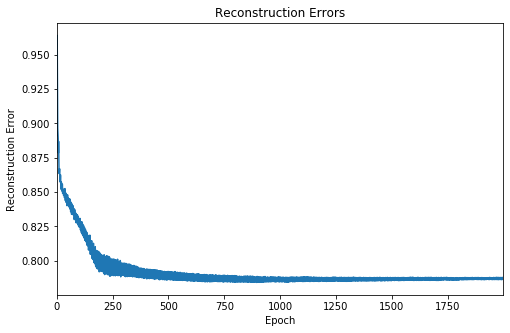

In [50]:
# Plot reconstruction errors

plt.figure(figsize=(8,5))
pd.Series(err).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors')
plt.show()

In [52]:
# Predicting ratings for validation set

inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)

finalOutput_validation, reconstructedOutput_validation, _ = rbm.rbm_output(inputValidation)

# Calculating MSE for validation set

predictionsArray = reconstructedOutput_validation
pred_validation = predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_validation, actual_validation)

print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 12.155106202209005


### Recommendations for a mock user

In [60]:
#mock user id
user=987

# Getting recommended books for mock user
unread, read = rbm.calculate_scores(reducedRatings, books, toread, rec, user)

# Listing recommended books for muck user
unread

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,book_name,book_authors,score
0,The Girl on the Train,Paula Hawkins,0.000000
1,The Road,Cormac McCarthy,0.489966
2,ねじまき鳥クロニクル [Nejimakidori kuronikuru],"Haruki Murakami, Jay Rubin",0.000007
3,Cloud Atlas,David Mitchell,0.000000


_________________________________________________________

By: Wendy Navarrete

November 2019